# Загрузка данных и библиотек

In [4515]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics

%matplotlib inline

In [4516]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяе

# Анализ источника данных

In [4517]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


# Предобработка

#### Вспомогательные функции и переменные

In [4518]:
RANDOM_STATE = 42

date_pattern = re.compile('\d+/\d+/\d+')
today = pd.to_datetime('today').date()
min_date = pd.to_datetime('1900-01-01').date()

good_words = ['good', 'delicious', 'best', 'gem', 'quick', 'top', 'great',
              'nice', 'lovely', 'cozy', 'cute', 'amazing', 'loved', 'friendly',
              'tasty', 'like', 'pleasant', 'fantastic', 'recommended', 'perfect',
              'outstanding', 'excellent', 'favourite', 'awesome', 'well',
              'wonderful', 'beautiful', 'enjoyable', 'super', 'reasonable',
              'affordable', 'welcoming', 'fine', 'fast', 'fabulous', 'favorite',
              'love', 'brilliant', 'pretty', 'interesting', 'charming', 'happy']

bad_words = ['pricey', 'slow', 'disappointing', 'expensive', 'worst', 'awful',
             'bad', 'terrible', 'rude', 'overpriced', 'avoid', 'horrible']

def describe_numerical(col, bins=100):
    """ Построение гистограммы и вывод основных статистических данных цифровых признаков"""

    df[col].hist(bins=bins)
    df[col].describe()


def describe_categorical(col):
    """ Вывод основных статистических данных категориальных признаков"""

    display(df[col].value_counts())
    display(df[col].describe())


def days_since_last_review(reviews):
    """Считает количество дней, прошедших со времени последнего отзыва"""

    review_dates = date_pattern.findall(reviews)
    last_review_date = min_date

    for review_date in review_dates:
        date = pd.to_datetime(review_date).date()

        if date > last_review_date:
            last_review_date = date

    return (today - last_review_date).days


def days_between_reviews(reviews):
    """Считает количество дней, прошедших между отзывами"""

    review_dates = date_pattern.findall(reviews)

    if len(review_dates) == 2:
        date1 = pd.to_datetime(review_dates[0]).date()
        date2 = pd.to_datetime(review_dates[1]).date()

        return abs((date1 - date2).days)

    return 0


def fill_cuisines(cuisines):
    """Преобразует строку, содержащую список в объект списка"""

    return ['Unknown'] if pd.isna(cuisines) else ast.literal_eval(cuisines)


def convert_price(price):
    """Преобразует строковое значение цены в числовое"""

    if price == '$':
        return 1
    elif price == '$$ - $$$':
        return 2
    elif price == '$$$$':
        return 3


def get_review_words(review):
    """Разбивает отзывы на отдельные слова"""

    review_words = set()
    word_pattern = re.compile('[A-Za-z]+')
    words = word_pattern.findall(review)

    for word in words:
        if word in good_words or word in bad_words:
            review_words.add(word)

    return list(review_words)


def rate_review(review):
    """Выставляет рейтинг по ключевым словам в отзывах"""

    rating = 0

    for word in review:
        if word in good_words:
            rating += 1
        if word in bad_words:
            rating -= 1

    return rating


# Анализ данных и создание признаков

## Аттрибут Restaurant_id

#### Анализ данных

In [4519]:
describe_categorical('Restaurant_id')

id_436      19
id_227      19
id_633      19
id_871      19
id_71       18
            ..
id_11079     1
id_10561     1
id_9360      1
id_9392      1
id_11315     1
Name: Restaurant_id, Length: 13094, dtype: int64

count      50000
unique     13094
top       id_436
freq          19
Name: Restaurant_id, dtype: object

#### Создание новых признаков

In [4520]:
# На основе данных анализа данных о Restaurant_id можем сделать вывод о наличии сетевых ресторанов
# и создать новый признак - является ли ресторан сетевым.
chain_restaurant = df['Restaurant_id'].value_counts().loc[lambda count: count > 1].index

df['Chain Restaurant'] = df['Restaurant_id'].apply(lambda r_id: 1 if r_id in chain_restaurant else 0)


## Аттрибут City

#### Анализ данных

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

count      50000
unique        31
top       London
freq        7193
Name: City, dtype: object

<AxesSubplot:>

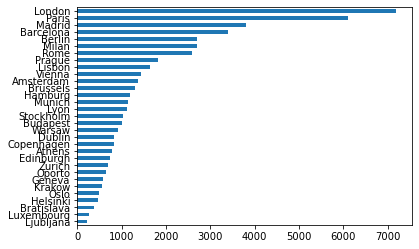

In [4521]:
describe_categorical('City')
df['City'].value_counts(ascending=True).plot(kind='barh')

#### Создание новых признаков

###### Является ли город столицей

In [4522]:
capitals = ['Paris','Stockholm','London','Berlin','Bratislava', 'Vienna','Rome',
            'Barcelona','Madrid','Dublin', 'Brussels','Warsaw','Budapest',
            'Copenhagen','Amsterdam','Hamburg','Lisbon','Prague','Oslo','Helsinki',
            'Ljubljana','Athens','Luxembourg']

df['Capital City'] = df['City'].apply(lambda city: 1 if city in capitals else 0)

###### Dummy-variables для городов

In [4523]:
city_ranges = pd.get_dummies(df['City'])

for c in city_ranges.columns:
    df[c] = city_ranges[c].values

## Аттрибут Cuisine Style

#### Анализ данных

In [4524]:
describe_categorical('Cuisine Style')

['Italian']                                                                                          1332
['French']                                                                                           1019
['Spanish']                                                                                           860
['French', 'European']                                                                                503
['Cafe']                                                                                              500
                                                                                                     ... 
['Italian', 'Mediterranean', 'Pizza', 'Argentinean', 'Vegetarian Friendly']                             1
['Japanese', 'Sushi', 'Asian', 'Seafood', 'Gluten Free Options', 'Vegetarian Friendly']                 1
['French', 'Wine Bar', 'European', 'Spanish', 'Vegetarian Friendly']                                    1
['Delicatessen', 'French']                    

count           38410
unique          10731
top       ['Italian']
freq             1332
Name: Cuisine Style, dtype: object

#### Очистка и преобразование данных, заполнение пропусков

In [4525]:
df['Cuisine Style'] = df['Cuisine Style'].apply(fill_cuisines)


#### Создание новых признаков

In [4526]:
df['Number of Cuisines'] = df['Cuisine Style'].apply(len)

## Аттрибут Ranking

#### Анализ данных

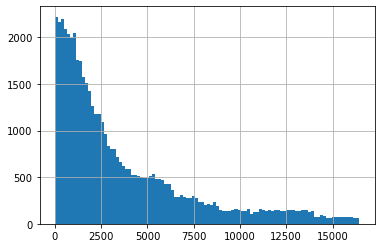

In [4527]:
describe_numerical('Ranking')


<AxesSubplot:>

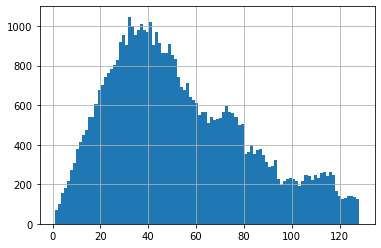

In [4528]:
# опытным путем выясняем, что взятие квадратного корня приводит данные к более нормальному виду, чем логарифм

np.sqrt(df['Ranking']).hist(bins=100)

#### Очистка и преобразование данных, заполнение пропусков


In [4529]:
# Будем использовать в модели нормализованные данные
df['Ranking'] = df['Ranking'].apply(np.sqrt)


## Аттрибут Rating

#### Анализ данных

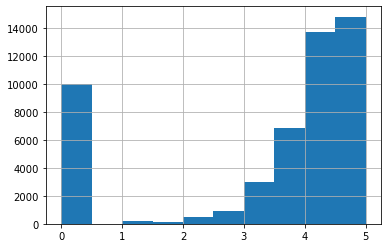

In [4530]:
describe_numerical('Rating', 10)


## Аттрибут Price Range

#### Анализ данных

In [4531]:
describe_categorical('Price Range')

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

count        32639
unique           3
top       $$ - $$$
freq         23041
Name: Price Range, dtype: object

#### Очистка и преобразование данных, заполнение пропусков

In [4532]:
# Заполним пропуски самым популярным значением
df['Price Range'] = df['Price Range'].fillna(df['Price Range'].value_counts().index[0])

# Попробуем преобразовать строковые значения.
# Это можно сделать двумя способами:

# Способ 1. Присвоение числового рангового значения, например $ - 1, $$-$$$ - 2, $$$$ - 3

# df['Price Range'] = df['Price Range'].apply(convert_price)

#### Создание новых признаков
###### Другой способ преобразования строковых значений цены

In [4533]:
price_ranges = pd.get_dummies(df['Price Range'])
price_ranges.columns = ['Inexpensive', 'Middle Price', 'Expensive']

for c in price_ranges.columns:
    df[c] = price_ranges[c].values

## Аттрибут Number of Reviews

#### Анализ данных

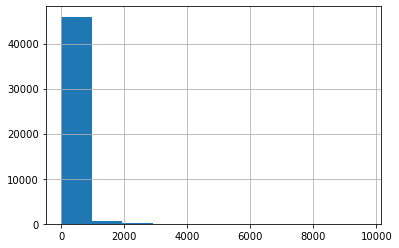

In [4534]:
describe_numerical('Number of Reviews', bins=10)


#### Очистка и преобразование данных, заполнение пропусков

<AxesSubplot:>

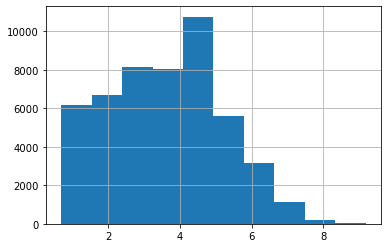

In [4535]:
# Заполним пропуски средним значением

df['Number of Reviews'] = df['Number of Reviews'].fillna(df['Number of Reviews'].mean())

# Опытным путем выясняем, что взятие логарифма приводит данные к более нормальному виду
np.log(df['Number of Reviews']).hist(bins=10)

In [4536]:
# Будем использовать в модели нормализованные данные
df['Number of Reviews'] = df['Number of Reviews'].apply(np.log)

## Аттрибут Reviews

#### Анализ данных

In [4537]:
describe_categorical('Reviews')

[[], []]                                                                                                              8112
[['Excellent food food', 'Fantastic sushi served tapas style'], ['09/07/2016', '02/21/2016']]                            2
[['Very cozy!', 'Service rate: 1'], ['01/17/2016', '11/18/2015']]                                                        2
[['Good Paella', 'Good enough. Nothing more'], ['09/20/2017', '05/29/2017']]                                             2
[['Absolutely authentic and delicious!', 'Wonderful discovery'], ['09/30/2017', '08/04/2016']]                           2
                                                                                                                      ... 
[['Nice place for a larger group', 'Nice outdoor setting, good food and tonigh...'], ['04/23/2017', '06/21/2016']]       1
[['Amazing', 'Excellent tea with a great atmosphere'], ['01/20/2018', '11/27/2017']]                                     1
[['Perfect eveni

count        49998
unique       41857
top       [[], []]
freq          8112
Name: Reviews, dtype: object

#### Очистка и преобразование данных, заполнение пропусков

In [4538]:
df['Reviews'] = df['Reviews'].fillna('')

#### Создание новых признаков

###### Количество дней между отзывами

In [4539]:
# df['Days Between Reviews'] = df['Reviews'].apply(days_between_reviews) # похоже, что признак немного ухудшает точность модели

###### Количество дней, прошедших с даты последнего отзыва

In [4540]:
df['Last Review Days'] = df['Reviews'].apply(days_since_last_review)

###### Рейтинг, основанный на положительных/отрицательных словах в отзывах

In [4541]:
# Если не использовать dummy-переменные Cities, то данные признаки незначительно увеличивают точность модели.
# При использовании Cities, точность модели наоборот уменьшается.
# df['Review Words'] = df['Reviews'].apply(get_review_words)
# df['Review Rating'] = df['Review Words'].apply(rate_review)
# #
# keywords = good_words + bad_words
# for word in keywords:
#     df[word] = df['Review Words'].apply(lambda w: 1 if word in w else 0)

# Корреляция между признаками

<AxesSubplot:>

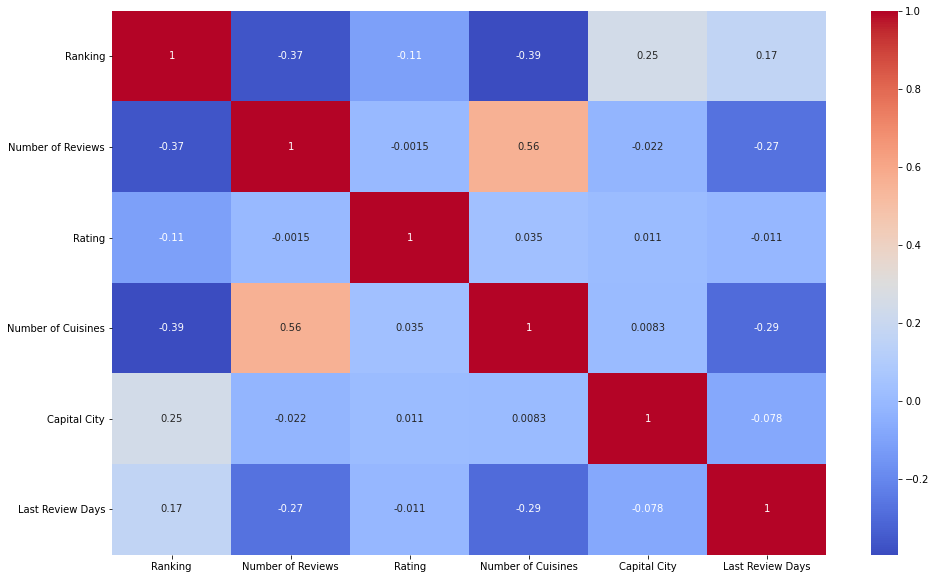

In [4542]:
plt.rcParams['figure.figsize'] = (16,10)
data_corr = df[['Cuisine Style', 'Ranking', 'Price Range', 'Number of Reviews',
                   'Rating', 'Number of Cuisines', 'Capital City', 'Last Review Days']]
sns.heatmap(data_corr.corr(), annot=True, cmap='coolwarm')

# По графику можно сделать выовод о том, что сильной корреляции между целевой переменной и остальными признаками нет
# Однако можно наблюдать небольшую корреляцию между количеством кухонь и количеством отзывов

# Удаляем столбцы с dtype Object

In [4543]:
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis=1, inplace=True)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [4544]:
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [4545]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)


In [4546]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 41), (40000, 41), (40000, 40), (32000, 40), (8000, 40))

# Создаём, обучаем и тестируем модель

In [4547]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [4548]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20981624999999998


# Исследуем ключевые признаки модели

<AxesSubplot:>

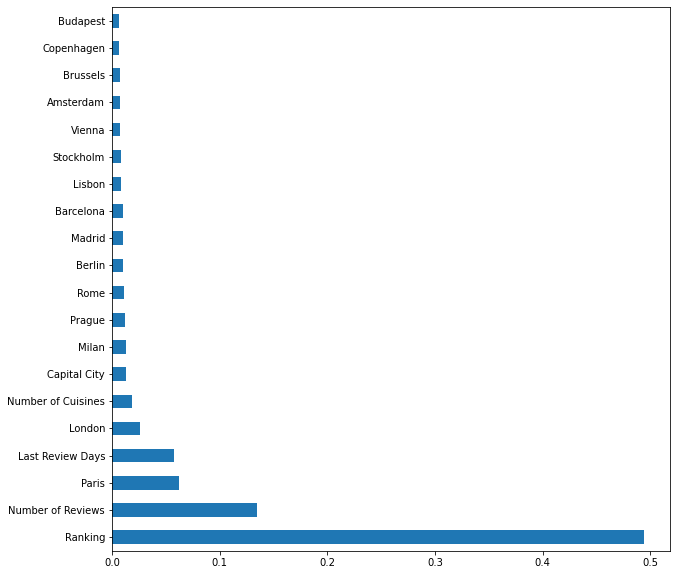

In [4549]:
plt.rcParams['figure.figsize'] = (10,10)
features = pd.Series(regr.feature_importances_, index=X.columns)
features.nlargest(20).plot(kind='barh')

# Готовим Kaggle Submission


In [4550]:
test_data = test_data.drop(['Rating'], axis=1)
predict_submission = regr.predict(test_data)

In [4551]:
predict_submission

array([3.085, 4.185, 4.48 , ..., 3.04 , 4.475, 4.405])

In [4552]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission_1.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.085
1,id_1,4.185
2,id_2,4.480
3,id_3,4.300
4,id_4,4.435
5,id_5,4.470
6,id_6,1.920
7,id_7,2.735
8,id_8,3.945
9,id_9,4.635
